In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


*italicized text*# **CNN Dataset**

In [ ]:
#!pip install datasets
#!pip install scikit-learn
#!pip install transformers

In [ ]:
from datasets import load_dataset

cnn_dataset = load_dataset('cnn_dailymail', '3.0.0')


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:


# Split the dataset into smaller portions (e.g. 1/10th of the original size)
train_size = int(0.01 * len(cnn_dataset['train']))
val_size = int(0.01 * len(cnn_dataset['validation']))
test_size = int(0.01 * len(cnn_dataset['test']))

train_data = cnn_dataset['train'].train_test_split(train_size=train_size)['train']
val_data = cnn_dataset['validation'].train_test_split(train_size=val_size)['train']
test_data = cnn_dataset['test'].train_test_split(train_size=test_size)['train']

cnn_dataset['train'] = train_data
cnn_dataset['validation'] = val_data
cnn_dataset['test'] = test_data

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Highlights: {example['highlights']}'")
        print(f"'>> Article: {example['article']}'")


show_samples(cnn_dataset)


'>> Highlights: The Olive Ridley turtles arrive at Ostional beach just before each new moon .
They form one of the biggest arribadas - mass synchronised nesting .'
'>> Article: By . Daily Mail Reporter . They are among thousands of endangered sea turtles who journey to the shore each year. The Olive Ridley turtles arrive at the beach just a few days before each new moon to form one of the biggest arribadas - mass synchronised nesting. As they arrive on land off the coast of Costa Rica, their large fins propel them forward and dig into the sand to decorate the beach with gentle waves. Scroll down for video . The Olive Ridley turtles arrive at the beach just a few days before each new moon to form one of the biggest arribadas - mass synchronised nesting . As they arrive on land off the coast of Costa Rica, their large fins propel them forward and dig into the sand to decorate the beach with gentle waves . Positioning themselves on the sand to nest, only the lapping surf and their soft g

In [ ]:
cnn_dataset = cnn_dataset.filter(lambda x: len(x["highlights"].split()) > 2)


Filter:   0%|          | 0/2871 [00:00<?, ? examples/s]

Filter:   0%|          | 0/133 [00:00<?, ? examples/s]

Filter:   0%|          | 0/114 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["highlights"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = cnn_dataset.map(preprocess_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/2871 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2871
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 114
    })
})

Graph representing top 50 words of highlights from the training part of the original dataset

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

word_counts = Counter()
for item in tokenized_datasets["train"]:
    # Remove punctuation characters
    article = item["highlights"].translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(article.lower())
    tokens = [token for token in tokens if token not in stop_words]
    word_counts.update(tokens)

# Get the 50 most common words and their frequencies
top_words = word_counts.most_common(50)
bottom_words = word_counts.most_common()[:-51:-1]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


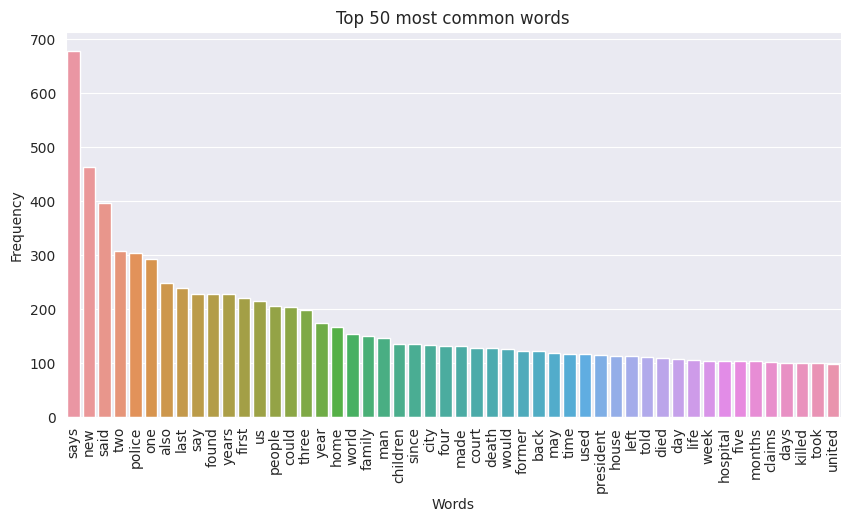

In [ ]:
# Plot the most common words
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.xticks(rotation=90)
plt.title("Top 50 most common words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


In [ ]:
!pip3 show transformers
!pip3 show tensorflow

Name: transformers
Version: 4.28.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 
Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, ten

In [ ]:
!python3 --version

Python 3.10.11


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    cnn_dataset["train"].column_names
)

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[ 1794,   259,   260, ...,   287, 44696,     1],
       [ 1794,   259,   260, ...,  4065,   702,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>, 'labels': <tf.Tensor: shape=(2, 30), dtype=int32, numpy=
array([[ 44096,   1425,   2101,   4165,    351,    674,    259,  68140,
           345,    304,    259,   9935,  10928,  67840, 160835,    264,
         64673,   5378,  77049,    259,    260,   7483,  14234,    345,
           288,    259,    265, 132558,  99885,      1],
       [   259,    277,    566,    898,    783,    288,   4657,    514,
           714,    332,    287,   9463,    304,   1037,   4256,    277,
           259,   6661,  25478,   4196,  35599,    259,    260,    259,
         75944,  30450,    541,    277,    263,      1]], dtype=int32)>, 'decoder_input_ids': <tf.Tensor: shape=(2, 30

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)
tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
from transformers import create_optimizer
import tensorflow as tf

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_epochs = 8
num_train_steps = len(tf_train_dataset) * num_train_epochs
model_name = model_checkpoint.split("/")[-1]

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10
179/179 [==============================] - 202s 884ms/step - loss: 11.0730 - val_loss: 4.2168
Epoch 2/10
179/179 [==============================] - 160s 891ms/step - loss: 6.8247 - val_loss: 3.4316
Epoch 3/10
179/179 [==============================] - 161s 897ms/step - loss: 5.9128 - val_loss: 3.1259
Epoch 4/10
179/179 [==============================] - 161s 902ms/step - loss: 5.4796 - val_loss: 2.9673
Epoch 5/10
179/179 [==============================] - 161s 897ms/step - loss: 5.2005 - val_loss: 2.8803
Epoch 6/10
179/179 [==============================] - 160s 896ms/step - loss: 5.0537 - val_loss: 2.8339
Epoch 7/10
179/179 [==============================] - 161s 900ms/step - loss: 4.9551 - val_loss: 2.8058
Epoch 8/10
179/179 [==============================] - 161s 898ms/step - loss: 4.8935 - val_loss: 2.7959
Epoch 9/10
179/179 [==============================] - 161s 901ms/step - loss: 4.8657 - val_loss: 2.7959
Epoch 10/10
179/179 [==============================] - 161s 900

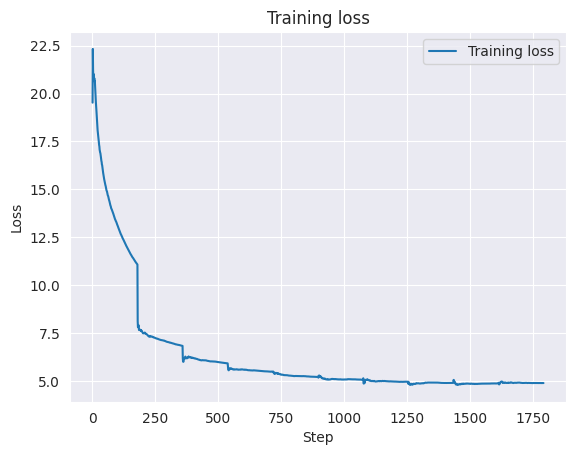

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

import matplotlib.pyplot as plt

class StepLossLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(StepLossLogger, self).__init__()
        self.step_losses = []
        self.steps = []

    def on_train_batch_end(self, batch, logs=None):
        self.step_losses.append(logs['loss'])
        self.steps.append(len(self.step_losses))

step_loss_logger = StepLossLogger()

history = model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset, epochs=10,
    callbacks=[step_loss_logger]
)

plt.plot(step_loss_logger.steps, step_loss_logger.step_losses, label='Training loss')
plt.title('Training loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
!pip3 show tensorflow
!pip3 show transformers

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl
Name: transformers
Version: 4.28.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
R

In [ ]:
!pip3 freeze

absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
datasets==2.12.0
db-dtypes==1.1.1
dbus-python==1.

In [ ]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from tqdm import tqdm
import numpy as np
from nltk.tokenize import sent_tokenize

generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=320
)

tf_generate_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    collate_fn=generation_data_collator,
    shuffle=False,
    batch_size=8,
    drop_remainder=True,
)


@tf.function(jit_compile=True)
def generate_with_xla(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=32,
    )


all_preds = []
all_labels = []
for batch, labels in tqdm(tf_generate_dataset):
    predictions = generate_with_xla(batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = labels.numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

100%|██████████| 16/16 [01:21<00:00,  5.12s/it]


In [ ]:
all_preds

['<extra_id_0>.\nLow says he has extended his contract to the 2018 World Cup in Russia.\nLow says he extended his contract to the 2018',
 '<extra_id_0> Dennis Tubieron in Leeds in April 11.\nThe 24-year-old is aiming to bring world titles to Leeds.\nThe',
 '<extra_id_0> in the home.\nThe victim was shot in the neck and chest.\nThe victim was shot in the neck and neck, neck and chest.\nThe victim',
 '<extra_id_0> Messi touched the ball on the first leg in the Champions League second round, Manchester City was eliminated from Champions League second round.\nManchester City was',
 "<extra_id_0> Kane was named on the bench.\nHarry Kane's goalscoring debut against Lithuania.\nHarry Kane was named on the bench",
 '<extra_id_0>.\nVioleta was playing in her front yard with her family before she ran in between two parked cars and onto Wilson Avenue and Olive',
 "<extra_id_0> against Levante on Sunday after their clash with Manchester City on Sunday.\nMarca splash on Bale's victory against",
 '<

Graph representing top 50 words in the Predicted summaries:

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

word_counts_pred = Counter()
for item in all_preds:
    # Remove punctuation characters
    article = item.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(article.lower())
    tokens = [token for token in tokens if token not in stop_words]
    word_counts_pred.update(tokens)

# Get the 50 most common words and their frequencies
top_words_pred = word_counts_pred.most_common(50)
bottom_words_pred = word_counts_pred.most_common()[:-51:-1]

print(top_words_pred)

[('extraid0', 128), ('says', 24), ('told', 17), ('said', 14), ('revealed', 13), ('arrested', 11), ('police', 11), ('found', 10), ('museum', 10), ('city', 9), ('mr', 8), ('five', 8), ('victim', 7), ('took', 7), ('court', 7), ('10', 7), ('wolfsburg', 7), ('taken', 7), ('games', 7), ('manchester', 6), ('suspended', 6), ('wednesday', 6), ('stone', 6), ('losing', 6), ('girls', 6), ('missing', 6), ('scotland', 6), ('suspected', 5), ('party', 5), ('group', 5), ('officer', 5), ('worcestershire', 5), ('world', 4), ('home', 4), ('neck', 4), ('league', 4), ('sunday', 4), ('officers', 4), ('cave', 4), ('last', 4), ('hotel', 4), ('appeared', 4), ('committee', 4), ('seven', 4), ('woman', 4), ('four', 4), ('jailed', 4), ('death', 4), ('stricken', 4), ('horse', 4)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


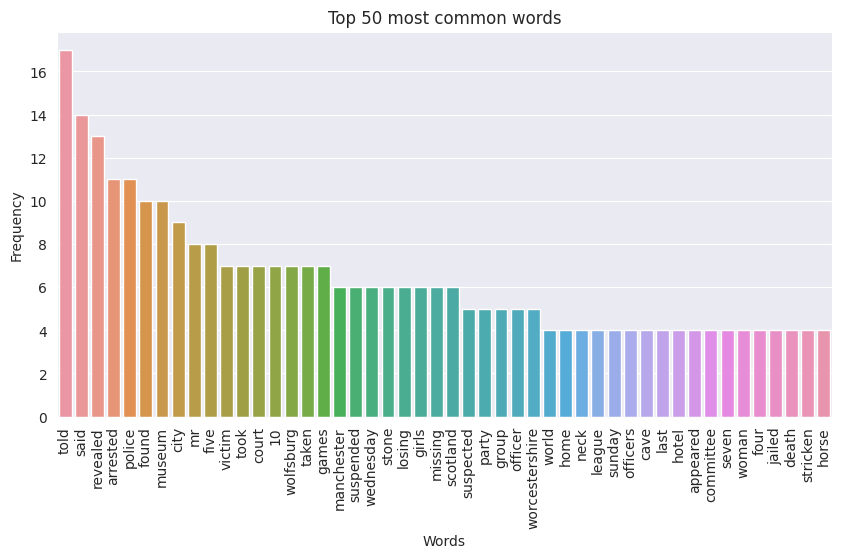

In [ ]:
# Plot the most common words
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.barplot(x=[word[0] for word in top_words_pred[2:]], y=[word[1] for word in top_words_pred[2:]])
plt.xticks(rotation=90)
plt.title("Top 50 most common words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
all_labels

['Joachim Low has extended his contract by two years to 2018.\nLow won the World Cup with Germany in Brazil last year.\nThe',
 'Featherweight Josh Warrington is undefeated in 20 professional fights.\nThe 24-year-old won his first fight abroad in',
 'Seven people - all in their early 20s - were shot in Panama City Beach.\nMultiple shots were fired',
 'Manchester City became the latest team to be eliminated from Europe.\nCity were dumped out of the Champions League last 16 by Barcelona',
 'Harry Kane scored on his England debut in 4-0 victory over Lithuania.\n21-year-old striker netted fourth just 80 second',
 'Shant Badleean, 55, of Glendale, California turned himself into police on Saturday following pleas for driver to come',
 "Gareth Bale scored a brace in Real Madrid's 2-0 win over Levante.\nGoals were Bale's first",
 'The 23-year-old man was one of dozens arrested in similar operations around Britain.\nAfter the hack, he allegedly wrote',
 'Ernest Reed Johnson, 25, was picked up by

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=ec85f2fe0235cfb6a5a39624dafcfb7ad49f128c7359b236f66412645d13f6ba
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
result = rouge_score.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True
)
result = {key: value * 100 for key, value in result.items()}
{k: round(v, 4) for k, v in result.items()}

{'rouge1': 22.1609, 'rouge2': 9.2177, 'rougeL': 18.1612, 'rougeLsum': 21.155}

In [ ]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=model)

Exception: ignored

In [ ]:
# performance comparison
# Convert the tokenized labels back to text
from tqdm import tqdm
def decode_label(tokenizer, labels):
    decoded_labels = []
    for label in labels:
        decoded_label = tokenizer.decode(label, skip_special_tokens=True)
        decoded_labels.append(decoded_label)
    return decoded_labels

# Generate predictions for the validation dataset
all_preds = []
for batch in tqdm(tf_eval_dataset):
    predictions = generate_with_xla(batch)
    decoded_preds = decode_label(tokenizer, predictions)
    all_preds.extend(decoded_preds)

# Get the actual labels for the validation dataset
all_labels = []
for item in tqdm(tokenized_datasets["validation"]):
    label = tokenizer.decode(item["labels"], skip_special_tokens=True)
    all_labels.append(label)

# Print some examples of actual and predicted summaries
for i in range(50):
    print(f"\nExample {i+1}:")
    print(f"\tActual summary: {all_labels[i]}")
    print(f"\tPredicted summary: {all_preds[i]}")
